In [1]:
import os,sys
sys.path.append('../')
import camb
import hmvec as hm
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import time

In [184]:
# Create model
zs = np.linspace(0.,3.,20)
ms = np.geomspace(2e10,1e17,200)
ks = np.geomspace(1e-4,100,1001)
hcos = hm.HaloModel(zs,ks,ms=ms)

xmax=20
nxs=5000

In [185]:
# Create profiles with preset parameter
hcos.add_battaglia_profile("electron",family="AGN",xmax=xmax,nxs=nxs)

/Volumes/Samsung_T5/Mac/Research/hmvec/Notebooks/../hmvec/fft.py:90: RuntimeWarning: invalid value encountered in true_divide
  uk = ukts/kts[None,None,:]/mnorm[...,None]


In [186]:
# Create new profile with different parameters
# The preset parameters are from battaglia_defaults['AGN'] found in the params.py file

parameters = {
    'rho0_A0': 4000,  # 4000
    'rho0_alpham': 0.29,  # 0.29
    'rho0_alphaz': -0.66,  # -0.66
    'alpha_A0': 0.88,  # 0.88
    'alpha_alpham': -0.03,  # -0.03
    'alpha_alphaz': 0.19,  # 0.19
    'beta_A0': 3.83,  # 3.83
    'beta_alpham': 0.08,  # 0.04
    'beta_alphaz': -0.025  # -0.025
}

hcos.add_battaglia_profile("electron1",family="AGN",xmax=xmax,nxs=nxs, \
                           param_override=parameters, ignore_existing=True)

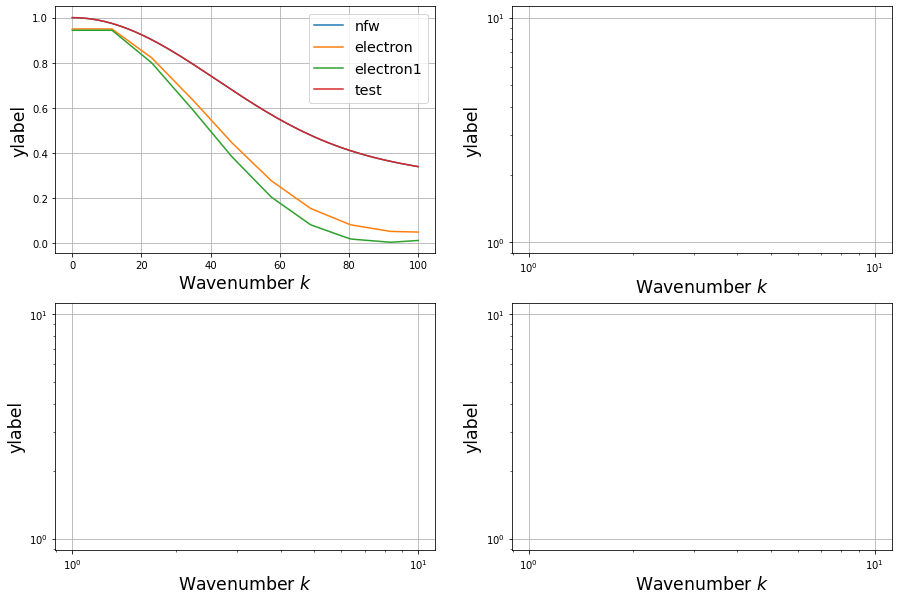

In [187]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.grid()
ax1.set_xlabel('Wavenumber $k$', fontsize='xx-large')
ax1.set_ylabel('ylabel', fontsize='xx-large')
for key in hcos.uk_profiles.keys():
    ax1.plot(ks, hcos.uk_profiles[key][0,0], label=key)
ax1.plot(ks, hcos.uk_profiles['nfw'][0,0], label='test')
ax1.legend(fontsize='x-large')


ax2.grid()
ax2.set_xlabel('Wavenumber $k$', fontsize='xx-large')
ax2.set_ylabel('ylabel', fontsize='xx-large')
ax2.set_xscale('log')
ax2.set_yscale('log')


ax3.grid()
ax3.set_xlabel('Wavenumber $k$', fontsize='xx-large')
ax3.set_ylabel('ylabel', fontsize='xx-large')
ax3.set_xscale('log')
ax3.set_yscale('log')


ax4.grid()
ax4.set_xlabel('Wavenumber $k$', fontsize='xx-large')
ax4.set_ylabel('ylabel', fontsize='xx-large')
ax4.set_xscale('log')
ax4.set_yscale('log')

plt.show()

In [188]:
# Assign the data, errors, and parameter bounds

x = ks
y = hcos.uk_profiles['electron1'][0,0]
yerr = np.array(len(hcos.uk_profiles['electron1'][0,0]) * [0.05])

parambounds = {
    'rho0_A0': (1000, 10000),  # 4000
    'rho0_alpham': (0.1, 0.99),  # 0.29
    'rho0_alphaz': (-0.99, -0.1),  # -0.66
    'alpha_A0': (0.1, 0.99),  # 0.88
    'alpha_alpham': (-0.099, -0.01),  # -0.03
    'alpha_alphaz': (0.1, 0.99),  # 0.19
    'beta_A0': (1, 9.99),  # 3.83
    'beta_alpham': (0.01, 0.099),  # 0.04
    'beta_alphaz': (-0.099, -0.01)  # -0.025
}

In [189]:
def battaglia_gas_fit1(m200critz,z,A0x,alphamx,alphazx):
    # Any factors of h in M?
    return A0x * (m200critz/1.e14)**alphamx * (1.+z)**alphazx

In [190]:
def rho_gas_generic_x1(x,m200critz,z,omb,omm,rhocritz,
                    gamma=hm.default_params['battaglia_gas_gamma'],
                    rho0_A0=hm.battaglia_defaults[hm.default_params['battaglia_gas_family']]['rho0_A0'],
                    rho0_alpham=hm.battaglia_defaults[hm.default_params['battaglia_gas_family']]['rho0_alpham'],
                    rho0_alphaz=hm.battaglia_defaults[hm.default_params['battaglia_gas_family']]['rho0_alphaz'],
                    alpha_A0=hm.battaglia_defaults[hm.default_params['battaglia_gas_family']]['alpha_A0'],
                    alpha_alpham=hm.battaglia_defaults[hm.default_params['battaglia_gas_family']]['alpha_alpham'],
                    alpha_alphaz=hm.battaglia_defaults[hm.default_params['battaglia_gas_family']]['alpha_alphaz'],
                    beta_A0=hm.battaglia_defaults[hm.default_params['battaglia_gas_family']]['beta_A0'],
                    beta_alpham=hm.battaglia_defaults[hm.default_params['battaglia_gas_family']]['beta_alpham'],
                    beta_alphaz=hm.battaglia_defaults[hm.default_params['battaglia_gas_family']]['beta_alphaz'],
):
#     start = time.time()
    
    rho0 = battaglia_gas_fit1(m200critz,z,rho0_A0,rho0_alpham,rho0_alphaz)  # ~5e-4
#     t1 = time.time()
#     print('Step 1', t1-start)
    
    alpha = battaglia_gas_fit1(m200critz,z,alpha_A0,alpha_alpham,alpha_alphaz)  # ~5e-4
#     t2 = time.time()
#     print('Step 2', t2-t1)
    
    beta = battaglia_gas_fit1(m200critz,z,beta_A0,beta_alpham,beta_alphaz)  # ~5e-4
    # Note the sign difference in the second gamma. Battaglia 2016 had a typo here.
#     t3 = time.time()
#     print('Step 3', t3-t2)
    
    value = (omb/omm) * rhocritz * rho0 * (x**gamma) * (1.+x**alpha)**(-(beta+gamma)/alpha)  # ~1
#     t4 = time.time()
#     print('Step 4', t4-t3)
    print(x.shape, alpha.shape, beta.shape)
    
    return value

In [191]:
from hmvec.fft import fft_integral

def generic_profile_fft1(rhofunc_x,cmaxs,rss,zs,ks,xmax,nxs,do_mass_norm=True):
    """
    Generic profile FFTing
    rhofunc_x: function that accepts vector spanning linspace(0,xmax,nxs)
    xmax:  some O(10-1000) dimensionless number specifying maximum of real space
    profile
    nxs: number of samples of the profile.
    cmaxs: typically an [nz,nm] array of the dimensionless cutoff for the profile integrals. 
    For NFW, for example, this is concentration(z,mass).
    For other profiles, you will want to do cmax = Rvir(z,m)/R_scale_radius where
    R_scale_radius is whatever you have divided the physical distance by in the profile to
    get the integration variable i.e. x = r / R_scale_radius.
    rss: R_scale_radius
    zs: [nz,] array to convert physical wavenumber to comoving wavenumber.
    ks: target comoving wavenumbers to interpolate the resulting FFT on to.
    
    """
#     start = time.time()
    
    xs = np.linspace(0.,xmax,nxs+1)[1:]  # ~1.2e-4
#     t1 = time.time()
#     print('step1', t1-start)
    
    rhos = rhofunc_x(xs)  # ~1.1
#     t2 = time.time()
#     print('step2', t2-t1)
    
    if rhos.ndim==1:  # ~1.75e-4
        rhos = rhos[None,None]
    else:
        assert rhos.ndim==3
#     t3 = time.time()
#     print('step3', t3-t2)

    rhos = rhos + cmaxs[...,None]*0.  # ~0.09
#     t4 = time.time()
#     print('step4', t4-t3)
    
    theta = np.ones(rhos.shape)  # ~0.06
#     t5 = time.time()
#     print('step5', t5-t4)
    
    theta[np.abs(xs)>cmaxs[...,None]] = 0  # ~0.04
    # CHECK
    # m
#     t6 = time.time()
#     print('step6', t6-t5)
    
    integrand = theta * rhos * xs**2.  # ~0.19
#     t7 = time.time()
#     print('step7', t7-t6)
    
    mnorm = np.trapz(integrand,xs)  # ~0.25
    # mass but off by norm same as rho is off by
#     t8 = time.time()
#     print('step8', t8-t7)
    
    if not(do_mass_norm):  # ~2e-4
        mnorm *= 0
        mnorm +=1
    # u(kt)
#     t9 = time.time()
#     print('step9', t9-t8)
    
    integrand = rhos*theta  # ~0.1
#     t10 = time.time()
#     print('step10', t10-t9)
    
    kts,ukts = fft_integral(xs,integrand)  # ~0.34
#     t11 = time.time()
#     print('step11', t11-t10)
    
    uk = ukts/kts[None,None,:]/mnorm[...,None]  # ~0.04
#     t12 = time.time()
#     print('step12', t12-t11)
    
    kouts = kts/rss/(1+zs[:,None,None])  # ~0.03
    # divide k by (1+z) here for comoving FIXME: check this!
#     t13 = time.time()
#     print('step13', t13-t12)
    
    ukouts = np.zeros((uk.shape[0],uk.shape[1],ks.size))  # ~3.4e-3
#     t14 = time.time()
#     print('step14', t14-t13)
    
    # sadly at this point we must loop to interpolate :(
    # from orphics import io
    # pl = io.Plotter(xyscale='loglog')
    for i in range(uk.shape[0]):  # ~0.09
        for j in range(uk.shape[1]):
            pks = kouts[i,j]
            puks = uk[i,j]
            puks = puks[pks>0]
            pks = pks[pks>0]
            ukouts[i,j] = np.interp(ks,pks,puks,left=puks[0],right=0)
            #TODO: Add compulsory debug plot here
    #         pl.add(ks,ukouts[i,j])
    # pl.hline(y=1)
    # pl.done()
#     t15 = time.time()
#     print('step15', t15-t14)
    
    return ks, ukouts

In [192]:
from hmvec.fft import generic_profile_fft

rhocritz = hcos.rho_critical_z(hcos.zs)
if hcos.mdef=='vir':
    delta_rhos1 = rhocritz*hcos.deltav(hcos.zs)
elif hcos.mdef=='mean':
    delta_rhos1 = hcos.rho_matter_z(hcos.zs)*200.
rvirs = hcos.rvir(hcos.ms[None,:],hcos.zs[:,None])
cs = hcos.concentration()
delta_rhos2 = 200.*hcos.rho_critical_z(hcos.zs)
m200critz = hm.mdelta_from_mdelta(hcos.ms,cs,delta_rhos1,delta_rhos2)
r200critz = hm.R_from_M(m200critz,hcos.rho_critical_z(hcos.zs)[:,None],delta=200.)

omb = hcos.p['ombh2'] / hcos.h**2.
omm = hcos.om0

rgs = r200critz/2.
cgs = rvirs/rgs


def model_func(pparams):
#     start = time.time()
    
    rhofunc = lambda x: rho_gas_generic_x1(x,m200critz[...,None],hcos.zs[:,None,None],omb,omm,rhocritz[...,None,None],
                                    gamma=0.2,
                                    rho0_A0=pparams['rho0_A0'],
                                    rho0_alpham=pparams['rho0_alpham'],
                                    rho0_alphaz=pparams['rho0_alphaz'],
                                    alpha_A0=pparams['alpha_A0'],
                                    alpha_alpham=pparams['alpha_alpham'],
                                    alpha_alphaz=pparams['alpha_alphaz'],
                                    beta_A0=pparams['beta_A0'],
                                    beta_alpham=pparams['beta_alpham'],
                                    beta_alphaz=pparams['beta_alphaz'])  # ~9.5e-7
#     t1 = time.time()
#     print('Step 1', t1-start)
    
    ks,ukouts= generic_profile_fft1(rhofunc,cgs,rgs[...,None],hcos.zs,hcos.ks,xmax,nxs)  # ~2.25
#     t2 = time.time()
#     print('Step 2', t2-t1)
    
    return ukouts

In [193]:
def log_likelihood(theta, x, y, yerr):
#     start=time.time()
    
    rho0_A0, rho0_alpham, rho0_alphaz, alpha_A0, alpha_alpham, \
    alpha_alphaz, beta_A0, beta_alpham, beta_alphaz = theta  # ~0.0
#     t1 = time.time()
#     print('Step 1', t1-start)
    
    model_params = {
        'rho0_A0': rho0_A0,  # 4000
        'rho0_alpham': rho0_alpham,  # 0.29
        'rho0_alphaz': rho0_alphaz,  # -0.66
        'alpha_A0': alpha_A0,  # 0.88
        'alpha_alpham': alpha_alpham,  # -0.03
        'alpha_alphaz': alpha_alphaz,  # 0.19
        'beta_A0': beta_A0,  # 3.83
        'beta_alpham': beta_alpham,  # 0.04
        'beta_alphaz': beta_alphaz  # -0.025
    }  # ~ 4.5e-4
#     t2 = time.time()
#     print('Step 2', t2-t1)

    model = model_func(model_params)[0,0]  # `2.25
#     t3 = time.time()
#     print('Step 3', t3-t2)
    
    value = -0.5 * np.sum((y - model) ** 2 / (yerr ** 2))  # ~ 2.5e-4
#     t4 = time.time()
#     print('Step 4', t4-t3)
    
    return value

In [194]:
def log_prior(theta):
    rho0_A0, rho0_alpham, rho0_alphaz, alpha_A0, alpha_alpham, \
    alpha_alphaz, beta_A0, beta_alpham, beta_alphaz = theta
    if list(parambounds.values())[0][0] < rho0_A0 < list(parambounds.values())[0][1] and \
    list(parambounds.values())[1][0] < rho0_alpham < list(parambounds.values())[1][1] and \
    list(parambounds.values())[2][0] < rho0_alphaz < list(parambounds.values())[2][1] and \
    list(parambounds.values())[3][0] < alpha_A0 < list(parambounds.values())[3][1] and \
    list(parambounds
         .values())[4][0] < alpha_alpham < list(parambounds.values())[4][1] and \
    list(parambounds.values())[5][0] < alpha_alphaz < list(parambounds.values())[5][1] and \
    list(parambounds.values())[6][0] < beta_A0 < list(parambounds.values())[6][1] and \
    list(parambounds.values())[7][0] < beta_alpham < list(parambounds.values())[7][1] and \
    list(parambounds.values())[8][0] < beta_alphaz < list(parambounds.values())[8][1]:
        return 0.0
    return -np.inf

In [195]:
def log_probability(theta, x, y, yerr):
#     start = time.time()
    
    lp = log_prior(theta)  # ~1.2e-5
#     t1 = time.time()
#     print('Step 1', t1-start)
    
    if not np.isfinite(lp):  # ~5.5e-4
        return -np.inf
#     t2 = time.time()
#     print('Step 2', t2-t1)
    
    loglike = log_likelihood(theta, x, y, yerr)  # ~2.25
#     t3 = time.time()
#     print('Step 3', t3-t2)
    
    value = lp + loglike  # ~1.6e-4
#     t4 = time.time()
#     print('Step 4', t4-t3)
    
    return value

In [196]:
log_probability(list(parameters.values()), x, y, yerr)

(5000,) (20, 200, 1) (20, 200, 1)


/var/folders/b6/43rgmqf97lnf7qw0h22h8f_80000gn/T/ipykernel_50187/376594516.py:75: RuntimeWarning: invalid value encountered in true_divide
  uk = ukts/kts[None,None,:]/mnorm[...,None]  # ~0.04


-9.26770660622852

In [181]:
pos = np.array(list(parameters.values())) + 1e-4 * np.random.randn(20, 9)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 100, progress=True);

/var/folders/b6/43rgmqf97lnf7qw0h22h8f_80000gn/T/ipykernel_50187/376594516.py:75: RuntimeWarning: invalid value encountered in true_divide
  uk = ukts/kts[None,None,:]/mnorm[...,None]  # ~0.04
100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 32.29it/s]
